In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model

In [2]:
#in this cell, we import the entire data and only selelct the rows corresponding to Mars
#entire_data = pd.read_pickle("Historic_Observations.df")
# Mars_data = entire_data[entire_data['Body'] == 'Mars']
# Mars_data.to_pickle("Mars_data.df")
# del(entire_data)
# del(Mars_data)

In [3]:
#This cell is used to read mars data
#Mars_data = pd.read_pickle("Mars_data.df")
#Mars_data = Mars_data.sort_values(by='JD') #sort it by Julian date

In [4]:
#This cell is to create training set and test set
# Mars_data.iloc[1132251:1135903].values.shape
# np.random.seed(1)
# test_JD = np.random.choice(Mars_data.iloc[1132251:1135903].values[:,0], 730, replace = False)
# tot_JD = Mars_data.iloc[1132251:1135903]['JD'].values
# test_mask = np.array([tot_JD[i] in test_JD for i in range(tot_JD.size)])
# test_JD = tot_JD[test_mask]
# training_mask = np.logical_not(test_mask)
# Mars_test = Mars_data.iloc[1132251:1135903][test_mask]
# Mars_training = Mars_data.iloc[1132251:1135903][training_mask]
# Mars_test.to_pickle("Mars_test.df")
# Mars_training.to_pickle("Mars_training.df")

In [6]:
#Read training/test set for Mars
Mars_test = pd.read_pickle("./data/Mars_test.df")
Mars_training = pd.read_pickle("./data/Mars_training.df")

In [7]:
#Get time, right ascension(RA), declination(dec) of Mars obsevation data
t_training = Mars_training['JD'].values
mars_dec_training = Mars_training['Dec'].values
mars_ra_training = Mars_training['RA'].values
t_test = Mars_test['JD'].values
mars_dec_test = Mars_test['Dec'].values
mars_ra_test = Mars_test['RA'].values

# Plot the training dataset

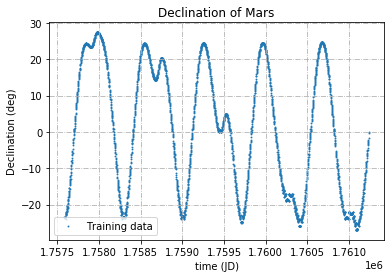

In [8]:
fig, ax = plt.subplots(1,1)
ax.scatter(t_training, mars_dec_training, s = 0.80, label='Training data')
ax.set_xlabel("time (JD)")
ax.set_ylabel("Declination (deg)")
ax.set_title("Declination of Mars")
ax.ticklabel_format(axis='x', style='sci', scilimits = (0,0))
ax.grid('on', ls = '-.')
ax.legend()


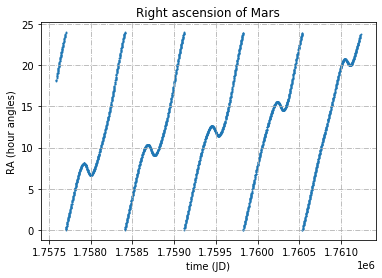

In [9]:
fig, ax = plt.subplots(1,1)
ax.scatter(t_training, mars_ra_training, s = 0.80, label='Training data')

ax.set_xlabel("time (JD)")
ax.set_ylabel("RA (hour angles)")
ax.set_title("Right ascension of Mars")
ax.tick_params(axis='both', which='major')
ax.grid('on', ls = '-.')
ax.ticklabel_format(axis='x', style='sci', scilimits = (0,0))



# Define Fourier featurization

In [10]:
def fourier_featurization(X, degree, phase=0):
    featurized_X = []
    for i in range(degree+1):
        if i == 0:
            featurized_X.append(np.ones((X.shape[0], 1))*1/np.sqrt(2 * degree + 1))
            #featurized_X.append(np.ones((X.shape[0], 1)))
        else:
            featurized_X.append(np.sqrt(2) * np.cos(i*(X[:,np.newaxis]+phase))/np.sqrt(2 * degree + 1))
            featurized_X.append(np.sqrt(2) * np.sin(i*(X[:,np.newaxis]+phase))/np.sqrt(2 * degree + 1))
    return np.hstack(featurized_X)

# Preprocess the data
**The time is scaled to be in range $[0,0.2\pi]$. Declination is linearly scaled to be in $[-1,1]$ range.**

In [11]:
x_test = (t_test - t_training.min())/(t_training.max()-t_training.min()) * np.pi * 2 * 0.1
x_training = (t_training - t_training.min())/(t_training.max()-t_training.min()) * np.pi * 2 * 0.1
y_test_dec = (mars_dec_test - mars_dec_training.min())/(mars_dec_training.max()-mars_dec_training.min()) * 2 -1
y_training_dec = (mars_dec_training - mars_dec_training.min())/(mars_dec_training.max()-mars_dec_training.min()) * 2 -1

**Fourier featurization of time. Degree of 100 (201 features) were used)**

In [12]:
feat_x_training = fourier_featurization(x_training, 100)
feat_x_test = fourier_featurization(x_test, 100)

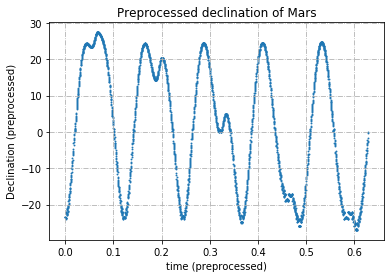

In [13]:
fig, ax = plt.subplots(1,1)
ax.scatter(x_training, mars_dec_training, s = 0.80, label='Training data')
ax.set_xlabel("time (preprocessed)")
ax.set_ylabel("Declination (preprocessed)")
ax.set_title("Preprocessed declination of Mars")
ax.tick_params(axis='both', which='major')
ax.grid('on', ls = '-.')

**Set up the linear model. To induce sparsity in the learned weights, Lasso regression is used**

In [14]:
dec_lasso = linear_model.Lasso(alpha = 1e-3)
#alpha defines the l1 regularization constant. 
#Increase this value will induce more sparsity, but possibly with high test error.
dec_lasso.fit(feat_x_training, y_training_dec.reshape(-1,1))

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

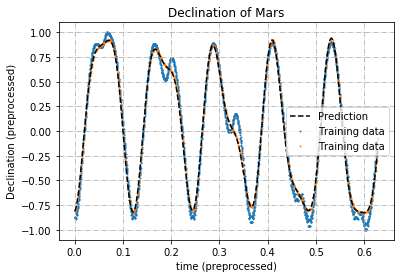

In [15]:
test_pred = dec_lasso.predict(feat_x_test)
training_pred = dec_lasso.predict(feat_x_training)

fig, ax = plt.subplots(1,1)

ax.scatter(x_training, y_training_dec, s = 0.80, label='Training data')
ax.plot(x_training, training_pred, ls = 'dashed', color = 'black', label = 'Prediction')
ax.scatter(x_test, test_pred, s = 0.80, label='Training data')

ax.set_xlabel("time (preprocessed)")
ax.set_ylabel("Declination (preprocessed)")
ax.set_title("Declination of Mars")
ax.tick_params(axis='both', which='major')
ax.grid('on', ls = '-.')
ax.legend()


**Get the test error**

In [16]:
loss = ((test_pred.ravel() - y_test_dec) ** 2).mean()
print(f"RMS error on the test set is {loss:.2e}")

RMS error on the test set is 5.40e-03


In [17]:
loss = (((test_pred.ravel() * (mars_dec_training.max()-mars_dec_training.min()) + mars_dec_training.min() - mars_dec_test)*np.pi/180) ** 2).mean()
print(f"RMS error on the test set is {loss:.2e}")

RMS error on the test set is 2.85e-01


**The function defined below converts the fourier feature frequencies to periods**

In [18]:
def convert_freq_to_periods(weights, scaling_factor):
    #from the number of weights, find the fourier degree
    weights = np.abs(weights[1::2]) + np.abs(weights[2::2])
    sorted_idx = np.argsort(-np.abs(weights))
    freq = (sorted_idx+1) / (10/scaling_factor)
    period = freq**-1 #years/cycle
    return period

In [19]:
periods = convert_freq_to_periods(dec_lasso.coef_, 0.1)

**Periods array contains all periods (frequencies) used for the fourier feature in the order of decreasing importance (absolute value of the learned weights). Note that the unit is in years/cycle**

**Note that the periods of the first two most important fourier features correspond to the orbital periods of Mars and the Earth, which are 1.88 years and 1 year, respectively.**

In [20]:
print(f"The most important learned period is {periods[0]:.2f} years per cycle")
print(f"The second most important learned period is {periods[1]:.2f} years per cycle")

The most important learned period is 1.89 years per cycle
The second most important learned period is 1.00 years per cycle


**Now, do the same with right ascension. For preprocessing, we scale the time to be in range $[0,0.2\pi]$.
In the dataset, RA is defined in hours. Moreover, when RA exceeds 24 hour angles, it suddenly becomes 0, making sharp drops which are difficult to be learned using Fourier features. For this reason, instead of learning RA directly, we learn cosine or sine of RA.**

In [21]:
#Preprocess the time
x_test = (t_test - t_training.min())\
/(t_training.max()-t_training.min()) * 2 * np.pi *0.1
x_training = (t_training - t_training.min())\
/(t_training.max()-t_training.min()) * 2 * np.pi *0.1

#Preprocess the RA values. First, we conver hour angles to radian, and then take cosine of it. 
y_test_ra = np.cos(mars_ra_test/24*2*np.pi)
y_training_ra = np.cos(mars_ra_training/24*2*np.pi)


**Visualize the RA training data**

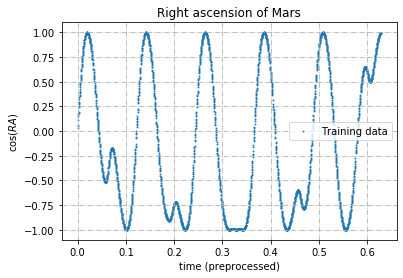

In [22]:
fig, ax = plt.subplots(1,1)
ax.scatter(x_training, y_training_ra, s = 0.80, label='Training data')
ax.set_xlabel("time (preprocessed)")
ax.set_ylabel(r"$\cos(RA)$")
ax.set_title("Right ascension of Mars")
ax.tick_params(axis='both', which='major')
ax.grid('on', ls = '-.')
ax.legend()

**Next, we learn the cosine of the RA data using Fourier features**

Mean test rms error is 8.73e-03


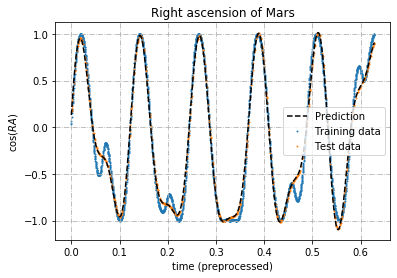

In [23]:
#Preprocess the time
feat_x_training = fourier_featurization(x_training, 100)
feat_x_test = fourier_featurization(x_test, 100)

#Train the model
ra_lasso = linear_model.Lasso(alpha = 1e-3)
ra_lasso.fit(feat_x_training, y_training_ra.reshape(-1,1))
#plot the results
fig, ax = plt.subplots(1,1)
ax.scatter(x_training, y_training_ra, s = 0.80, label='Training data')

test_pred_y = ra_lasso.predict(feat_x_test)

loss = ((test_pred_y.ravel() - y_test_ra) ** 2).mean()
print(f"Mean test rms error is {loss:.2e}")
cos_ra_pred = ra_lasso.predict(feat_x_training)

ax.plot(x_training, ra_lasso.predict(feat_x_training), ls = 'dashed', color = 'black', label = 'Prediction')
ax.scatter(x_test, ra_lasso.predict(feat_x_test), s = 0.80, label='Test data')

ax.set_xlabel("time (preprocessed)")
ax.set_ylabel(r"$\cos(RA)$")
ax.set_title("Right ascension of Mars")
ax.tick_params(axis='both', which='major')
ax.grid('on', ls = '-.')
ax.legend()

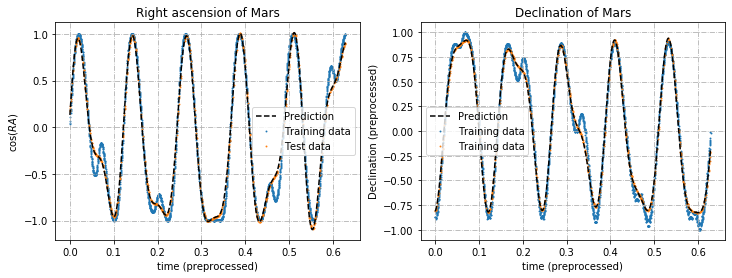

In [24]:
#plot the results side-by-side
fig, ax = plt.subplots(1,2, figsize = (12,4))
ax[0].scatter(x_training, y_training_ra, s = 0.80, label='Training data')

test_pred_y = ra_lasso.predict(feat_x_test)

loss = ((test_pred_y.ravel() - y_test_ra) ** 2).mean()

cos_ra_pred = ra_lasso.predict(feat_x_training)

ax[0].plot(x_training, ra_lasso.predict(feat_x_training), ls = 'dashed', color = 'black', label = 'Prediction')
ax[0].scatter(x_test, ra_lasso.predict(feat_x_test), s = 0.80, label='Test data')

ax[0].set_xlabel("time (preprocessed)")
ax[0].set_ylabel(r"$\cos(RA)$")
ax[0].set_title("Right ascension of Mars")
ax[0].tick_params(axis='both', which='major')
ax[0].grid('on', ls = '-.')
ax[0].legend()


ax[1].scatter(x_training, y_training_dec, s = 0.80, label='Training data')
ax[1].plot(x_training, dec_lasso.predict(feat_x_training), ls = 'dashed', color = 'black', label = 'Prediction')
ax[1].scatter(x_test, dec_lasso.predict(feat_x_test), s = 0.80, label='Training data')

ax[1].set_xlabel("time (preprocessed)")
ax[1].set_ylabel("Declination (preprocessed)")
ax[1].set_title("Declination of Mars")
ax[1].tick_params(axis='both', which='major')
ax[1].grid('on', ls = '-.')
ax[1].legend()



In [25]:
periods = convert_freq_to_periods(ra_lasso.coef_, 0.1)

In [26]:
print(f"The most important learned period is {periods[0]:.2f} years per cycle")
print(f"The second most important learned period is {periods[1]:.2f} years per cycle")

The most important learned period is 1.89 years per cycle
The second most important learned period is 1.00 years per cycle


**Make a stem plot to see some of the learned weights**

In [27]:
periods = convert_freq_to_periods(ra_lasso.coef_, 0.1)

In [28]:
freq = (np.arange(int(ra_lasso.coef_.size-1)/2)+1)/(10/0.1)

/Users/jaewon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


Text(0.5, 0, 'Fourier feature periods (years/cycle)')

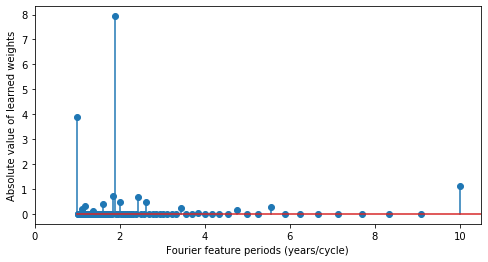

In [29]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
ax.stem(freq**-1, np.abs(ra_lasso.coef_[1::2])+np.abs(ra_lasso.coef_[2::2]))
ax.set_xlim(0,10.5)
ax.set_ylabel("Absolute value of learned weights")
ax.set_xlabel("Fourier feature periods (years/cycle)")